In [2]:
import harp
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from functools import reduce
import cv2
import numpy as np
import utils
import aeon.io.video as video
import aeon.analysis.movies as frame_helpers
from dotmap import DotMap

harp_reader = harp.create_reader('device.yml', epoch=harp.REFERENCE_EPOCH)
session_data_reader = utils.SessionData()
rules_reader = utils.SessionData()
video_reader = utils.Video()

harp_datafolder = r'../temp_data/2024-07-02T15-39-47/Expander/'
settings_datafolder = r'../temp_data/2024-07-02T15-39-47/SessionSettings/'
rules_datafolder = r'../temp_data/2024-07-02T15-39-47/RuleSettings/'
video_datafolder = r'../temp_data/2024-07-02T15-39-47/VideoData/'
output_event_folder = r'../temp_data/2024-07-02T15-39-47/EventResults/'

In [3]:
# read experiment metadata
session_settings = utils.load_json(session_data_reader, settings_datafolder)

rule_settings = utils.load_json(rules_reader, rules_datafolder)

print(session_settings)
print(rule_settings)

                                                                     metadata
2024-07-02 15:39:37.717504  {'lineMappings': {'odorMap': [DotMap(name='Odo...
                                                                     metadata
2024-07-02 15:39:37.717504  {'ruleAlias': 'Rule1', 'stateDefinitions': [{'...
2024-07-08 22:28:35.631487  {'ruleAlias': 'Rule2', 'stateDefinitions': [{'...
2024-07-08 22:31:39.745471  {'ruleAlias': 'Rule1', 'stateDefinitions': [{'...
2024-07-09 20:02:44.003488  {'ruleAlias': 'Rule2', 'stateDefinitions': [{'...


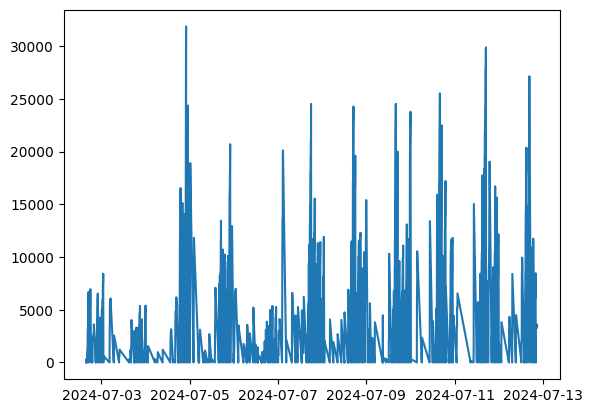

In [4]:
# read experiment video
video_data = utils.load_video(video_reader, video_datafolder)

plt.plot(video_data.index, video_data["_frame"])

In [5]:
# Read HARP device streams, conditioned on mappings found in the session metadata
metadata = session_settings.iloc[0]['metadata']
print(metadata.metadata.animalId)

# Extract line mappings from metadata
aux_line = f'Aux{metadata.lineMappings.auxLine}'
port_line = f'Out{metadata.lineMappings.portLine}'
vacuum_line = f'Out{metadata.lineMappings.vacuumLine}'
odorA = f"Out{next((x.line for x in metadata.lineMappings.odorMap if x.name=='OdorA'), None)}"
odorB = f"Out{next((x.line for x in metadata.lineMappings.odorMap if x.name=='OdorB'), None)}"
odorC = f"Out{next((x.line for x in metadata.lineMappings.odorMap if x.name=='OdorC'), None)}"

# Aux line containing poke events
poke_events = utils.load(harp_reader.AuxInState, harp_datafolder)[aux_line]

# times when outputs were set to HIGH (e.g. port valve opening, manifold valve opening)
outputs_HIGH = utils.load(harp_reader.OutputSet, harp_datafolder)
# times when outputs were set to LOW (e.g. port valve closing, manifold closing)
outputs_LOW = utils.load(harp_reader.OutputClear, harp_datafolder)

print(outputs_LOW[odorC])

# convert LOW and HIGH events to port state dataframes
line_states = {
    "poke_events": poke_events,
    "port_line_state": utils.concat_digi_events(outputs_LOW[port_line], outputs_HIGH[port_line]),
    "vacuum_line_state": utils.concat_digi_events(outputs_LOW[vacuum_line], outputs_HIGH[vacuum_line]),
    "odorA_state": utils.concat_digi_events(outputs_LOW[odorA], outputs_HIGH[odorA]),
    "odorB_state": utils.concat_digi_events(outputs_LOW[odorB], outputs_HIGH[odorB]),
    "odorC_state": utils.concat_digi_events(outputs_LOW[odorC], outputs_HIGH[odorC]),
}

# consolidate digital lines into as single DataFrame
merged = pd.merge(line_states["poke_events"], line_states["port_line_state"], left_on="Time", right_on="Time", how="outer") \
        .merge(line_states["vacuum_line_state"], left_on="Time", right_on="Time", how="outer") \
        .merge(line_states["odorA_state"], left_on="Time", right_on="Time", how="outer") \
        .merge(line_states["odorB_state"], left_on="Time", right_on="Time", how="outer") \
        .merge(line_states["odorC_state"], left_on="Time", right_on="Time", how="outer")

# rename columns according to metadata line mapping
merged.columns = line_states.keys()

# add additional meta information
merged['poke_count'] = (merged['poke_events'] * 1).cumsum(skipna=True).ffill()
merged['odor_count'] = (merged['odorA_state'] * 1).cumsum(skipna=True).ffill() + (merged['odorB_state'] * 1).cumsum(skipna=True).ffill() + \
                       (merged['odorC_state'] * 1).cumsum(skipna=True).ffill()

print(merged)


CK023
Time
2024-07-02 15:40:23.489535809    False
2024-07-02 15:40:23.556479931    False
2024-07-02 15:40:23.558495998    False
2024-07-02 15:40:23.559487820     True
2024-07-02 15:40:23.669536114    False
                                 ...  
2024-07-12 20:45:38.288479805    False
2024-07-12 20:45:38.301536083    False
2024-07-12 20:53:33.486495972    False
2024-07-12 20:53:33.487520218    False
2024-07-12 20:53:33.489535809     True
Name: Out8, Length: 33111, dtype: bool
                              poke_events port_line_state vacuum_line_state  \
Time                                                                          
2024-07-02 15:40:21.621984005        True             NaN               NaN   
2024-07-02 15:40:21.644703865       False             NaN               NaN   
2024-07-02 15:40:23.489535809         NaN           False               NaN   
2024-07-02 15:40:23.556479931         NaN             NaN               NaN   
2024-07-02 15:40:23.558495998         NaN      

C:\Users\erski\AppData\Local\Temp\ipykernel_10192\3915912841.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged['poke_count'] = (merged['poke_events'] * 1).cumsum(skipna=True).ffill()
C:\Users\erski\AppData\Local\Temp\ipykernel_10192\3915912841.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged['odor_count'] = (merged['odorA_state'] * 1).cumsum(skipna=True).ffill() + (merged['odorB_state'] * 1).cumsum(skipna=True).ffill() + \
C:\Users\erski\AppData\Local\Temp\ipykernel_10192\3915912841.py:46: FutureWarning: Downcasting object dtype arra

In [9]:
# Extract initiating events
merged["initiating_event"] = False

diffs = (merged["port_line_state"].ffill() * 1).diff()
vacuum_state = merged["vacuum_line_state"].ffill() * 1
port_events = merged["port_line_state"][(diffs==1) & ((vacuum_state==0) | (pd.isnull(vacuum_state)))]

for i in port_events.index:
    pre_events = merged[merged.index <= (i - pd.Timedelta(seconds=metadata.metadata.minimumPokeTime))]
    initiating_poke_event = pre_events[pre_events["poke_events"] == True].iloc[[-1]]
    merged.loc[initiating_poke_event.index, "initiating_event"] = True
    
merged['initiating_event_count'] = (merged['initiating_event'] * 1).cumsum(skipna=True).ffill()
print(merged)

                              poke_events port_line_state vacuum_line_state  \
Time                                                                          
2024-07-02 15:40:21.621984005        True             NaN               NaN   
2024-07-02 15:40:21.644703865       False             NaN               NaN   
2024-07-02 15:40:23.489535809         NaN           False               NaN   
2024-07-02 15:40:23.556479931         NaN             NaN               NaN   
2024-07-02 15:40:23.558495998         NaN             NaN               NaN   
...                                   ...             ...               ...   
2024-07-12 20:45:38.289535999         NaN             NaN               NaN   
2024-07-12 20:45:38.301536083         NaN             NaN             False   
2024-07-12 20:53:33.486495972         NaN             NaN               NaN   
2024-07-12 20:53:33.487520218         NaN             NaN               NaN   
2024-07-12 20:53:33.489535809         NaN           

In [13]:
# Using the consolidated data sets, do an example plot centered around a poke event

def extract_event_info(experiment_state: pd.DataFrame, rule_state: pd.DataFrame, event_time: pd.Timestamp, time_offset: float, metadata: DotMap):
    # get time window around event
    start_time = event_time - pd.Timedelta(seconds=time_offset)
    end_time = event_time + pd.Timedelta(seconds=time_offset)

    # slice data in this time window
    event_data = experiment_state[start_time : end_time]
    event_vid = video_data[start_time : end_time]

    # additional meta information
    animal_id = metadata.metadata.animalId
    cur_state = experiment_state.ffill().loc[experiment_state.index <= event_time].iloc[[-1]]
    current_rule = rule_state[rule_state.index <= event_time]["metadata"].iloc[-1]

    cur_odor = [state for state in ['odorA_state', 'odorB_state', 'odorC_state'] if cur_state[state][0]==True]
    cur_odor = cur_odor[0] if len(cur_odor)>0 else None
    if cur_odor is None:
        odor_name = 'None'
        odor_line = np.nan
    else:
        odor_name = cur_odor.split('_')[0].capitalize()
        odor_name = odor_name[:-1] + odor_name[-1].upper()
        odor_line = [o.line for o in metadata.lineMappings.odorMap if o.name==odor_name][0]

    time_beam_break_on = event_time
    time_beam_break_off = experiment_state.loc[(experiment_state['poke_events'] == False) & (experiment_state.index > event_time)].index[0]

    (experiment_state.loc[(experiment_state.index > event_time)]["port_line_state"]==True).any()
    time_port_open = experiment_state.loc[(experiment_state['port_line_state'] == True) & (experiment_state.index > event_time)].index[0] if \
    (experiment_state.loc[(experiment_state.index > event_time)]["port_line_state"]==True).any() else None
    time_port_close = experiment_state.loc[(experiment_state['port_line_state'] == False) & (experiment_state.index > event_time)].index[0] if \
    (experiment_state.loc[(experiment_state.index > event_time)]["port_line_state"]==False).any() else None

    time_odor_open = experiment_state.loc[(experiment_state[cur_odor] == True) & (experiment_state.index <= event_time)].index[0] if cur_odor else None
    time_odor_close = experiment_state.loc[(experiment_state[cur_odor] == False) & (experiment_state.index > event_time)].index[0] if cur_odor else None

    next_poke_valves = (experiment_state[experiment_state.index > time_port_close])[['odorA_state', 'odorB_state', 'odorC_state']].sum(axis=1) if time_port_close else None
    next_odor_time = next_poke_valves[next_poke_valves == 1].index[0] if (next_poke_valves is not None) else np.nan
    next_poke_time = experiment_state.loc[(experiment_state.index > time_port_close) & (experiment_state['poke_events'] == True)]['poke_events'] if time_port_close else []
    next_poke_time = (next_poke_time.index[0] if (len(next_poke_time)>0) else np.nan)

    # summarise in data frame
    event_df = pd.DataFrame({
        'animal_id': animal_id,
        'current_rule': current_rule.ruleAlias,
        'current_odor': odor_name,
        'odor_line': odor_line,
        'port_line': metadata.lineMappings.portLine,
        'vacuum_line': metadata.lineMappings.vacuumLine,
        'aux_line': metadata.lineMappings.auxLine,
        'poke_state': cur_state['poke_events'],
        'initiating_event': cur_state['initiating_event'],
        'port_line_state': cur_state['port_line_state'],
        'vacuum_line_state': cur_state['vacuum_line_state'],
        'odorA_state': cur_state['odorA_state'],
        'odorB_state': cur_state['odorB_state'],
        'odorC_state': cur_state['odorC_state'],
        'beam_break_count': cur_state['poke_count'],
        'odor_count': cur_state['odor_count'],
        'initiating_event_count': cur_state['initiating_event_count'],
        'beam_break_on': time_beam_break_on,
        'beam_break_off': time_beam_break_off,
        'port_open': time_port_open,
        'port_close': time_port_close,
        'odor_open': time_odor_open,
        'odor_close': time_odor_close,
        'next_odor': next_odor_time,
        'next_poke': next_poke_time
    })

    return event_data, event_vid, event_df

# Get all the poke onset events, then extract the event times
poke_events = merged["poke_events"][merged["poke_events"]==True]
poke_event_times = [poke_events.iloc[[t]].index[0] for t in range(len(poke_events))]
    
results = [extract_event_info(merged, rule_settings, t, 2.0, metadata) for t in poke_event_times]
print(results)
summary = pd.concat([r[2] for r in results])
summary.to_csv(f'{output_event_folder}summary.csv')

C:\Users\erski\AppData\Local\Temp\ipykernel_10192\32602849.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cur_state = experiment_state.ffill().loc[experiment_state.index <= event_time].iloc[[-1]]
C:\Users\erski\AppData\Local\Temp\ipykernel_10192\32602849.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cur_odor = [state for state in ['odorA_state', 'odorB_state', 'odorC_state'] if cur_state[state][0]==True]
C:\Users\erski\AppData\Local\Temp\ipykernel_10192\32602849.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change i

KeyboardInterrupt: 

C:\Users\neurogears\AppData\Local\Temp\ipykernel_36096\2673367156.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.plot(event_data["poke_events"].ffill(), drawstyle = 'steps-post')
C:\Users\neurogears\AppData\Local\Temp\ipykernel_36096\2673367156.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.plot(event_data["vacuum_line_state"].ffill() + 2.2, drawstyle = 'steps-post')
C:\Users\neurogears\AppData\Local\Temp\ipykernel_36096\2673367156.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, i

[Text(0, -0.25, 'event'),
 Text(0, 0.55, 'poke'),
 Text(0, 1.65, 'port_line'),
 Text(0, 2.75, 'vacuum_line'),
 Text(0, 3.85, 'odorA'),
 Text(0, 4.95, 'odorB'),
 Text(0, 6.05, 'odorC'),
 Text(0, 7.05, 'video_frames')]

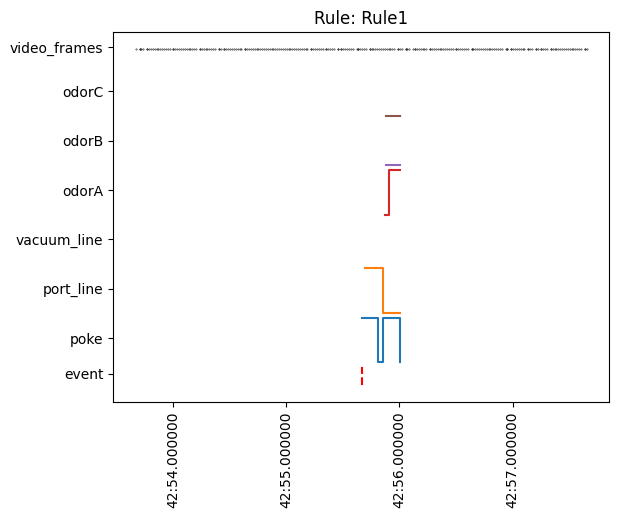

In [88]:
# Construct a plot of one of these results
event_idx = 99
event_data = results[event_idx][0]
event_vid = results[event_idx][1]
event_df = results[event_idx][2]
fig = plt.figure()

plt.plot([event_df.index[0], event_df.index[0]], [-0.5, -0.1], c='r', linestyle='dashed')
plt.plot(event_data["poke_events"].ffill(), drawstyle = 'steps-post')
plt.plot(event_data["port_line_state"].ffill() + 1.1, drawstyle = 'steps-post')
plt.plot(event_data["vacuum_line_state"].ffill() + 2.2, drawstyle = 'steps-post')
plt.plot(event_data["odorA_state"].ffill() + 3.3, drawstyle = 'steps-post')
plt.plot(event_data["odorB_state"].ffill() + 4.4, drawstyle = 'steps-post')
plt.plot(event_data["odorC_state"].ffill() + 5.5, drawstyle = 'steps-post')
plt.scatter(event_vid.index, np.ones((1, len(event_vid.index))) * 7, c='k', s=0.1)
plt.xticks(rotation=90)
plt.title(f"Rule: {event_df['current_rule'][0]}")

ax = fig.axes[0]
ax.set_yticks([-0.25, 0.55, 1.65, 2.75, 3.85, 4.95, 6.05, 7.05])
ax.set_yticklabels(['event', 'poke', 'port_line', 'vacuum_line', 'odorA', 'odorB', 'odorC', 'video_frames'])

In [102]:
def create_event_video(experiment_state: pd.DataFrame, event_frame_data: pd.DataFrame, event_df: pd.DataFrame):
    # get all frames
    frames = [f for f in video.frames(event_frame_data)]

    # create annotated video
    annotated_frames = []
    event_time = event_df.index
    for i, f in enumerate(frames):
        cur_t = event_frame_data.index[i]
        relative_t = (cur_t - event_time)[0].total_seconds()
        state_history = experiment_state.ffill().loc[experiment_state.index <= cur_t]
        if len(state_history) == 0:
            continue
        cur_state = experiment_state.ffill().loc[experiment_state.index <= cur_t].iloc[-1]
        current_rule = event_df["current_rule"][0]

        odor_count = int(cur_state["odor_count"]) if not np.isnan(cur_state["odor_count"]) else "no odor"

        cv2.putText(f, f'Animal : {metadata.metadata.animalId}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2, 1)

        cv2.putText(f, f'Rule : {current_rule}', (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2, 1)
        cv2.putText(f, f'HARP Time : {cur_t}', (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2, 1)
        cv2.putText(f, f'Current stimulus : {odor_count}', (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2, 1)
        cv2.putText(f, f'Time to event (s) : {relative_t}', (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2, 1)

        cv2.putText(f, f"Aux state : {cur_state.fillna(False)['poke_events']}", (10, 180), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0) if cur_state.fillna(False)['poke_events'] else (0, 0, 255), 2, 1)
        cv2.putText(f, f"Port state : {cur_state['port_line_state']}", (10, 210), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0) if cur_state['port_line_state']==True else (0, 0, 255), 2, 1)
        cv2.putText(f, f"OdorA state : {cur_state['odorA_state']}", (10, 240), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0) if cur_state['odorA_state']==True else (0, 0, 255), 2, 1)
        cv2.putText(f, f"OdorB state : {cur_state['odorB_state']}", (10, 270), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0) if cur_state['odorB_state']==True else (0, 0, 255), 2, 1)
        cv2.putText(f, f"OdorC state : {cur_state['odorC_state']}", (10, 300), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0) if cur_state['odorC_state']==True else (0, 0, 255), 2, 1)

        cv2.putText(f, f"Poke count : {cur_state['poke_count']}", (10, 330), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2, 1)
        annotated_frames.append(f)

    return annotated_frames
        
for i, r in enumerate(results):
    annotated = create_event_video(merged, r[1], r[2])

    odor_count = int(r[2]["odor_count"].iloc[0]) if not np.isnan(r[2]["odor_count"].iloc[0]) else "no-odor"

    vid_path = f'{output_event_folder}Stimulus-{odor_count}-Event-{(i+1)}-{str(r[2].index[0]).replace(" ", "").replace(":", "T")}.mp4'

    print(vid_path)
    video.export(annotated, vid_path, 50)

C:\Users\neurogears\AppData\Local\Temp\ipykernel_36096\2926295919.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  state_history = experiment_state.ffill().loc[experiment_state.index <= cur_t]
C:\Users\neurogears\AppData\Local\Temp\ipykernel_36096\2926295919.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cur_state = experiment_state.ffill().loc[experiment_state.index <= cur_t].iloc[-1]
C:\Users\neurogears\AppData\Local\Temp\ipykernel_36096\2926295919.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future 

../temp_data_remote/2024-06-04T18-56-34/EventResults/Stimulus-no_odor-Event-1-2024-06-0418T59T47.943295956.mp4
../temp_data_remote/2024-06-04T18-56-34/EventResults/Stimulus-no_odor-Event-2-2024-06-0418T59T48.735424042.mp4
../temp_data_remote/2024-06-04T18-56-34/EventResults/Stimulus-no_odor-Event-3-2024-06-0418T59T49.694303989.mp4
../temp_data_remote/2024-06-04T18-56-34/EventResults/Stimulus-no_odor-Event-4-2024-06-0419T00T25.112127781.mp4
../temp_data_remote/2024-06-04T18-56-34/EventResults/Stimulus-no_odor-Event-5-2024-06-0419T00T25.195136070.mp4
../temp_data_remote/2024-06-04T18-56-34/EventResults/Stimulus-no_odor-Event-6-2024-06-0419T00T29.456128120.mp4
../temp_data_remote/2024-06-04T18-56-34/EventResults/Stimulus-1-Event-7-2024-06-0419T00T51.332640171.mp4
../temp_data_remote/2024-06-04T18-56-34/EventResults/Stimulus-2-Event-8-2024-06-0419T00T59.352191925.mp4
../temp_data_remote/2024-06-04T18-56-34/EventResults/Stimulus-2-Event-9-2024-06-0419T00T59.426688194.mp4
../temp_data_remote

KeyboardInterrupt: 